In [1]:
from scipy import io as spio
import numpy as np
# Датасет руписних літер
emnist = spio.loadmat("letters_CNN/emnist-letters.mat")

# Завантаження тренувальної вибірки
X_train = emnist["dataset"][0][0][0][0][0][0]
X_train = X_train.astype(np.float32)

# Завантаження тренувальної вибірки
y_train = emnist["dataset"][0][0][0][0][0][1]

# Завантаження тестової вибірки
X_test = emnist["dataset"][0][0][1][0][0][0]
X_test = X_test.astype(np.float32)

# Завантаження тестової вибірки
y_test = emnist["dataset"][0][0][1][0][0][1]


In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
def preds_batch(X, y, batch_size):
    rnd_idx = np.arange((len(X_test)))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch 

In [3]:
X_train.shape

(124800, 784)

In [4]:
X_train_labels = X_train.reshape(X_train.shape[0], 28, 28, order="A")
X_test_labels = X_test.reshape(X_test.shape[0], 28, 28, order="A")

y_train = y_train.ravel()
y_test = y_test.ravel()

train_labels = y_train
test_labels = y_test

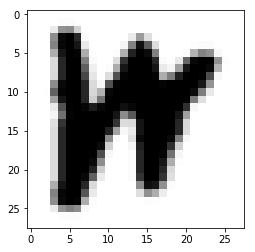

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(X_train_labels[0],cmap=plt.cm.binary)
plt.show()

In [6]:
X_train /= 255.0
X_test /= 255.0

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [7]:
import tensorflow as tf

height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 256
fc1_dropout_rate = 0.5

n_outputs = 27

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [8]:
n_epochs = 1000
batch_size = 100

n_batches = len(X_test) // batch_size
batch_acc = 0.0
predictions = np.array([]).reshape(-1, n_outputs)

best_loss_val = np.infty
checks_since_last_progress = 0
max_checks_without_progress = 20

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid, y: y_valid})
        if loss_val < best_loss_val:
            save_path = saver.save(sess, "./emnist_letters_CNN.ckpt")
            best_loss_val = loss_val
            checks_since_last_progress = 0
        else:
            checks_since_last_progress += 1
            if checks_since_last_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))

        

with tf.Session() as sess:
    saver.restore(sess, "./emnist_letters_CNN.ckpt")
    for X_batch, y_batch in shuffle_batch(X_test, y_test, batch_size): 
        batch_acc += accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        
    for X_batch, y_batch in preds_batch(X_test, y_test, batch_size):    
        batch_preds = Y_proba.eval(feed_dict={X: X_batch, y: y_batch})
        predictions = np.append(predictions, batch_preds, axis=0)
    acc_test = batch_acc / n_batches
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))


Epoch 0, last batch accuracy: 94.0000%, valid. accuracy: 92.1600%, valid. best loss: 0.239797
Epoch 1, last batch accuracy: 99.0000%, valid. accuracy: 93.0800%, valid. best loss: 0.210584
Epoch 2, last batch accuracy: 95.0000%, valid. accuracy: 93.1400%, valid. best loss: 0.210584
Epoch 3, last batch accuracy: 95.0000%, valid. accuracy: 93.1400%, valid. best loss: 0.200580
Epoch 4, last batch accuracy: 95.0000%, valid. accuracy: 93.3200%, valid. best loss: 0.200580
Epoch 5, last batch accuracy: 98.0000%, valid. accuracy: 93.2600%, valid. best loss: 0.200580
Epoch 6, last batch accuracy: 97.0000%, valid. accuracy: 93.1400%, valid. best loss: 0.200580
Epoch 7, last batch accuracy: 99.0000%, valid. accuracy: 93.1200%, valid. best loss: 0.200580
Epoch 8, last batch accuracy: 97.0000%, valid. accuracy: 93.2800%, valid. best loss: 0.200580
Epoch 9, last batch accuracy: 100.0000%, valid. accuracy: 93.3000%, valid. best loss: 0.200580
Epoch 10, last batch accuracy: 98.0000%, valid. accuracy: 9

In [9]:
print(np.argmax(predictions[5]))

1


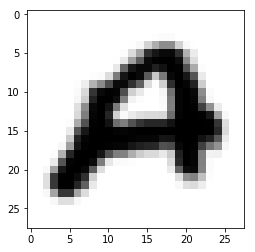

In [10]:
plt.imshow(X_test_labels[5],cmap=plt.cm.binary)
plt.show()

In [11]:
# Декодування літер з масиву-прогнозування
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

preds = np.array(one_hot_decode(predictions))

print(preds.shape)
print(y_test.shape)

(20800,)
(20800,)


In [12]:
# Підрахунок правильних і неправльних результатів
correct = np.where(preds==y_test)[0]
incorrect = np.where(preds!=y_test)[0]

print(correct.shape)
print(incorrect.shape)

(19388,)
(1412,)


In [13]:
# К-сть картинок для зображення
n_view = incorrect.shape[0]

In [14]:
from numpy.random import permutation

# Отримання випадкового вибору з правильно-прогнозованих картинок
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [15]:
# Створення масиву випадкових результатів
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

imgs = X_test_labels[idx]
imgs_incorrect = X_test_labels[idx_incorrect]

imgs.shape

(1412, 28, 28)

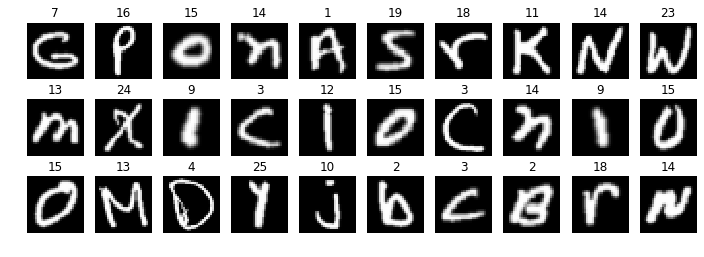

In [16]:
"""
A a = 1
B b = 2
C c = 3
D d = 4
E e = 5
F f = 6
G g = 7
H h = 8
I i = 9
J j = 10
K k = 11
L l = 12
M m = 13
N n = 14
O o = 15
P p = 16
Q q = 17
R r = 18
S s = 19
T t = 20
U u = 21
V v = 22
W w = 23
X x = 24
Y y = 25
Z z = 26 
"""
# Зображення перших 30 картинок рупоисних літер
f = plt.figure(figsize=(12,4))

for i in range(30):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img, cmap='gray')